In [1]:

from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset

from torch.nn import CrossEntropyLoss, MSELoss

from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention, ClipLinear
from utils_glue import *
from bertviz import model_view

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0 
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def do_eval(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels, teacher_model=None):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for batch_ in tqdm(eval_dataloader, desc="Inference"):
        batch_ = tuple(t.to(device) for t in batch_)
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # teacher attnmap test
            if teacher_model is not None:
                
                # logits, _, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
                
                # # logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_probs=teacher_probs)
                # logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_probs=(teacher_probs, teacher_values, teacher_reps))
                teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
                logits, student_atts, student_reps, student_probs, student_values  = model(input_ids, segment_ids, input_mask, teacher_outputs=(teacher_probs, teacher_values, teacher_reps, teacher_logits, teacher_atts), output_mode=output_mode, seq_lengths=seq_lengths)
            else:
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask)
        
        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss
    return result

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":1,"eval_step": 50}, # No Aug : 50 Aug : 400
        "mnli": {"max_seq_length": 128,"batch_size":1,"eval_step":8000},
        "mrpc": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "sst-2": {"max_seq_length": 64,"batch_size":1,"eval_step":100},
        "sts-b": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "qqp": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":1,"eval_step": 20}
    }

def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids


In [14]:
task_name = "rte"
bert_size = "large"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else: 
    layer_num = 12
    head_num = 12
    
teacher_model = None

# torch.cuda.empty_cache()
# !nvidia-smi

# Device & Dataset

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

teacher_model_dir = os.path.join(model_dir,task_name)

# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(teacher_model_dir, do_lower_case=True)


# Load Dataset
data_dir = os.path.join("data",task_name)
processed_data_dir = os.path.join(data_dir,'preprocessed')

eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
# dev_file = train_file = os.path.join(processed_data_dir,'dev.pkl') 
# eval_features = pickle.load(open(dev_file,'rb'))

eval_data, eval_labels = get_tensor_data("classification", eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

eval_examples = processor.get_dev_examples(data_dir)

# Sampling Sentence 
i = 0 
# num = 3
num = 42

for step, batch in enumerate(eval_dataloader):
    # model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    seq_length = seq_lengths[0]
    i = i + 1
    if i == num:
        break

input_ids_sliced = input_ids[:,:seq_length]
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)


sample_sentence_a = str()
sample_sentence_b = str()
index = 0

for i, word in enumerate(tokens[1:-1]):
    if word == "[SEP]":
        break
    sample_sentence_a += word
    sample_sentence_a += " "
index = i

for i, word in enumerate(tokens[index+2:-1]):
    if word == "[SEP]":
        break
    sample_sentence_b += word
    sample_sentence_b += " "

sep_index = torch.where(input_ids[0] == 102)[0]

if len(sample_sentence_b) > 1:
    sample_sentence_b_start = segment_ids[0].tolist().index(1)
else:
    sample_sentence_b_start = None

print(f"input_ids : {input_ids_sliced}")
print(f"tokens : {tokens}")
print(f"A : {sample_sentence_a}")
print(f"B : {sample_sentence_b}")
print(sep_index)

for i, token in enumerate(tokens):
    tokens[i] = token + "_" + str(i)


06/09 10:12:49 PM Writing example 0 of 277
06/09 10:12:49 PM *** Example ***
06/09 10:12:49 PM guid: dev-0
06/09 10:12:49 PM tokens: [CLS] dana reeve , the widow of the actor christopher reeve , has died of lung cancer at age 44 , according to the christopher reeve foundation . [SEP] christopher reeve had an accident . [SEP]
06/09 10:12:49 PM input_ids: 101 11271 20726 1010 1996 7794 1997 1996 3364 5696 20726 1010 2038 2351 1997 11192 4456 2012 2287 4008 1010 2429 2000 1996 5696 20726 3192 1012 102 5696 20726 2018 2019 4926 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/09 10:12:49 PM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# Attention Output Comp


In [16]:
teacher_model_dir = os.path.join(model_dir,task_name)
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()

06/09 10:12:57 PM Loading model models/BERT_large/rte/pytorch_model.bin
06/09 10:12:58 PM loading model...
06/09 10:12:58 PM done!
06/09 10:12:58 PM Weights from pretrained model not used in BertForSequenceClassification: ['bert.embeddings.position_ids']


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [17]:
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_model(input_ids_sliced.to(device))

In [22]:
mag_dict = dict()
for l in range(layer_num):        
    mag_dict[f"attn_min_{l}"] = []; mag_dict[f"attn_max_{l}"] = []; 
    mag_dict[f"ffn_min_{l}"] = []; mag_dict[f"ffn_max_{l}"] = []; 
    mag_dict[f"sa_min_{l}"] = []; mag_dict[f"sa_max_{l}"] = []; 
    mag_dict[f"sa_ffn_min_{l}"] = []; mag_dict[f"sa_ffn_max_{l}"] = []; 

for l in range(layer_num):
        tc_attn_context, tc_attn_output, tc_value_vector, tc_sa_output = teacher_zip[l]
        # st_attn_context, st_attn_output, st_value_vector, st_sa_output = student_zip[l]        
        # st_ffn_output = student_zip[2][1+1]
        tc_ffn_output = teacher_reps[l]
        
        tc_output = tc_attn_output
        # st_output = st_attn_output
        
        for token in range(len(tokens)):
          
            mag_dict[f"attn_min_{l}"].append(tc_attn_output[0,token,:].min().item())
            mag_dict[f"attn_max_{l}"].append(tc_attn_output[0,token,:].max().item())
            
            mag_dict[f"ffn_min_{l}"].append(tc_ffn_output[0,token,:].min().item())
            mag_dict[f"ffn_max_{l}"].append(tc_ffn_output[0,token,:].max().item())
            
            mag_dict[f"sa_min_{l}"].append(tc_sa_output[0,token,:].min().item())
            mag_dict[f"sa_max_{l}"].append(tc_sa_output[0,token,:].max().item())
            
            mag_dict[f"sa_ffn_min_{l}"].append((tc_ffn_output+tc_sa_output)[0,token,:].min().item())
            mag_dict[f"sa_ffn_max_{l}"].append((tc_ffn_output+tc_sa_output)[0,token,:].max().item())

token_len=68
for l in range(layer_num):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(4, 1, figsize=(10, 10), dpi=70)
    ax1.plot(list(range(token_len)), mag_dict[f"ffn_min_{l}"], label="v2_ffn_min", color="tab:red", linewidth=2.5)
    ax1.plot(list(range(token_len)), mag_dict[f"ffn_max_{l}"], label="v2_ffn_max", color="tab:red", linewidth=2.5)
    
    ax2.plot(list(range(token_len)), mag_dict[f"sa_min_{l}"], label="v2_sa_min", color="orangered", linewidth=2.5)
    ax2.plot(list(range(token_len)), mag_dict[f"sa_max_{l}"], label="v2_sa_max", color="orangered", linewidth=2.5)
    
    ax3.plot(list(range(token_len)), mag_dict[f"sa_ffn_min_{l}"], label="v2_sa+ffn_min", color="c", linewidth=2.5)
    ax3.plot(list(range(token_len)), mag_dict[f"sa_ffn_max_{l}"], label="v2_sa+ffn_max", color="c", linewidth=2.5)
    
    ax4.plot(list(range(token_len)), mag_dict[f"attn_min_{l}"], label="v2_attn_min", color="dodgerblue", linewidth=2.5)
    ax4.plot(list(range(token_len)), mag_dict[f"attn_max_{l}"], label="v2_attn_max", color="dodgerblue", linewidth=2.5)
    
    
    ax1.set_title(f"Layer {l}", fontsize=15)
    ax1.legend(loc=2, fontsize=15)
    ax2.legend(loc=2, fontsize=15)
    ax3.legend(loc=2, fontsize=15)
    ax4.legend(loc=2, fontsize=15)
    
    plt.xticks(rotation=60, fontsize=10)
    
#     ax2.plot(list(range(152)), mag_dict[f"tc_min_{l}"], label="v1_FP_min", color="tab:blue", linewidth=2.5)
#     ax2.plot(list(range(152)), mag_dict[f"tc_max_{l}"], label="v1_FP_max", color="tab:blue", linewidth=2.5)
#     ax2.legend(loc=2, fontsize=15)
#     ax2.set_xlabel("Token Number", fontsize=3)

    plt.show()




In [79]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

student_model_dir = os.path.join(model_dir,task_name)

# Teacher Model Build
teacher_model_dir = os.path.join(model_dir,task_name)
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()
model = teacher_model
    
ternary_name = "ternary_save"
sarq_name_1 = "1SB_O"
sarq_name_2 = "1SB_S"
sarq_name_3 = "1SB_LSM_O"
sarq_name_4 = "1SB_LSM_M"

model_list = [sarq_name_1, sarq_name_2]
model_num = 0
mag_dict = dict()

for st_model_name in model_list:
    # Student Model Build
    if model_num == 0:
        student_model_dir = os.path.join(model_dir,task_name)
        quant_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
        student_config = BertConfig.from_pretrained(quant_dir)
    else:
        student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
        student_config = BertConfig.from_pretrained(student_model_dir)             
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    model = student_model

    # Quantization Option ACT/WEIGHT
    for name, module in student_model.named_modules():
        if isinstance(module, (QuantizeLinear, QuantizeAct, ClipLinear)):    
            module.act_flag = True
            module.weight_flag = True

    for l in range(layer_num):        
        mag_dict[f"{model_num}_min_{l}"] = []; mag_dict[f"{model_num}_max_{l}"] = []; mag_dict[f"{model_num}_std_{l}"] = []; mag_dict[f"{model_num}_mean_{l}"] = []
        if model_num == 0:
            mag_dict[f"tc_min_{l}"] = []; mag_dict[f"tc_max_{l}"] = []; mag_dict[f"tc_std_{l}"] = []; mag_dict[f"tc_mean_{l}"] = []
    
    student_model.eval()
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)
    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_model(input_ids_sliced.to(device))
    student_logits, student_atts, student_reps, student_probs, student_zip  = model(input_ids_sliced.to(device), teacher_outputs=(teacher_probs, teacher_zip, teacher_reps, teacher_logits, teacher_atts), output_mode=output_mode, seq_lengths=seq_lengths)
    for l in range(layer_num):
        tc_attn_context, tc_attn_output, tc_value_vector, tc_sa_output = teacher_zip[l]
        st_attn_context, st_attn_output, st_value_vector, st_sa_output = student_zip[l]        
        st_ffn_output = student_zip[2][1+1]
        tc_ffn_output = teacher_reps[l+1]
        
        tc_output = tc_attn_output
        st_output = st_attn_output
        
        for token in range(len(tokens)):
            if model_num == 0:
                mag_dict[f"tc_min_{l}"].append(tc_output[0,token,:].min().item())
                mag_dict[f"tc_max_{l}"].append(tc_output[0,token,:].max().item())
                mag_dict[f"tc_mean_{l}"].append(tc_output[0,token,:].mean().item())
                mag_dict[f"tc_std_{l}"].append(tc_output[0,token,:].std().item())
            
            mag_dict[f"{model_num}_min_{l}"].append(st_output[0,token,:].min().item())
            mag_dict[f"{model_num}_max_{l}"].append(st_output[0,token,:].max().item())
            mag_dict[f"{model_num}_mean_{l}"].append(st_output[0,token,:].mean().item())
            mag_dict[f"{model_num}_std_{l}"].append(st_output[0,token,:].std().item())

    model_num += 1

06/07 11:15:29 PM Loading model models/rte/pytorch_model.bin
06/07 11:15:29 PM loading model...
06/07 11:15:30 PM done!
06/07 11:15:30 PM loading configuration file output/rte/exploration/1SB_O/config.json
06/07 11:15:31 PM Loading model models/rte/pytorch_model.bin
06/07 11:15:32 PM loading model...
06/07 11:15:32 PM done!
06/07 11:15:32 PM loading configuration file output/rte/exploration/1SB_S/config.json
06/07 11:15:34 PM Loading model output/rte/exploration/1SB_S/pytorch_model.bin
06/07 11:15:34 PM loading model...
06/07 11:15:34 PM done!


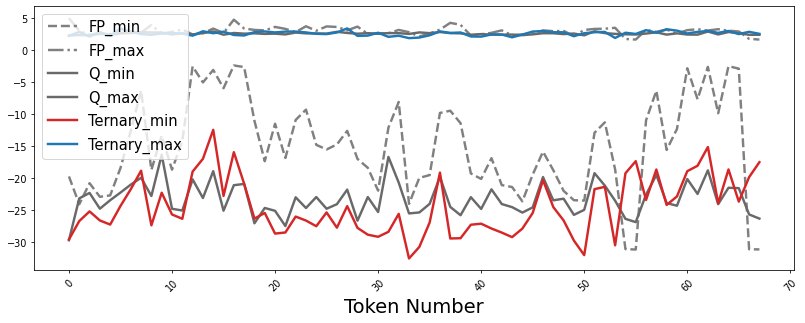

In [81]:
model_num = 0
for l in range(layer_num):
    l = 11
    fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi=70)
    ax.plot(list(range(len(tokens))), mag_dict[f"tc_min_{l}"], label="FP_min", color="gray", linewidth=2.5, linestyle="--")
    ax.plot(list(range(len(tokens))), mag_dict[f"tc_max_{l}"], label="FP_max", color="gray", linewidth=2.5, linestyle="-.")
    # ax.plot(tokens, mag_dict[f"tc_mean_{l}"], label="tc_mean", color="r")

    ax.plot(list(range(len(tokens))), mag_dict[f"0_min_{l}"], label="Q_min", color="dimgray", linewidth=2.5)
    ax.plot(list(range(len(tokens))), mag_dict[f"0_max_{l}"], label="Q_max", color="dimgray", linewidth=2.5)
    
    ax.plot(list(range(len(tokens))), mag_dict[f"1_min_{l}"], label="Ternary_min", color="tab:red", linewidth=2.5)
    ax.plot(list(range(len(tokens))), mag_dict[f"1_max_{l}"], label="Ternary_max", color="tab:blue", linewidth=2.5)
    
    # ax.plot(tokens, mag_dict[f"2_min_{l}"], label="1SB_LSM_M", color="b", linestyle="-.")
    # ax.plot(tokens, mag_dict[f"2_max_{l}"], label="1SB_LSM_M", color="b", linestyle="-.")
    # ax.plot(tokens, mag_dict[f"{model_num}_mean_{l}"], label="st_mean", color="dodgerblue")
    # ax.set_title(f"Attention Output Layer {l}", fontsize=20)
    ax.legend(loc=2, fontsize=15)
    plt.xticks(rotation=45, fontsize=10)
    ax.set_xlabel("Token Number", fontsize=20)
    plt.show()
    break